# Create Neural Net

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [104]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from kaggle_environments import evaluate, make, utils

env = make("connectx", debug=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
seed_value = 23
torch.manual_seed(seed_value)
random.seed(seed_value)

class ValueNetwork(nn.Module):
    def __init__(self, convFilters, filterSize, boardRows, boardCols):
        """
        Input board as 3 channel image.
        Convolutional Layer with ReLU and fully-connected output of one value.
        Args:
            convFilters: number of conv filter
            filterSize: Conv filter size (kernel size)
            boardRows: Number of rows for board
            boardCols: Number of cols for board
        """
        super().__init__()
        self.boardRows = boardRows
        self.boardCols = boardCols
        self.conv_layer = nn.Conv2d(3, convFilters, filterSize)
        # Add 2 for mark one hot encoded
        self.linear_layer1 = nn.Linear((boardRows-filterSize+1) * (boardCols-filterSize+1) * convFilters  + 2, 1000)
        self.linear_layer2 = nn.Linear(1000, 1000)
        self.output_layer = nn.Linear(1000, 1)
        
    def forward(self, board, mark):
        """
        Args:
            board: serialized board from env observation
            mark: who's turn is it
        """
        board = torch.as_tensor(board).to(DEVICE)
        mark = torch.as_tensor(mark-1).to(DEVICE)
        
        # Reshape and one hot board: shape -> (3, rows, cols)
        board = board.reshape((6, 7))
        board = F.one_hot(board, 3)
        board = board.transpose(0, 2).transpose(1,2)
        board = board.type(torch.float)
        
        conv_output = F.relu(self.conv_layer(board))
        mark = F.one_hot(mark, 2)
        add_mark = torch.cat((conv_output.flatten(), mark))
        
        output = F.relu(self.linear_layer1(add_mark))
        output = F.relu(self.linear_layer2(output))
        output = self.output_layer(output)
        return output

# Helper functions

In [103]:
def get_valid_actions(env, board):
    return [c for c in range(env.configuration.columns) if board[c] == 0]

def simulate_play(board, column, mark, config):
    EMPTY = 0
    columns = config.columns
    rows = config.rows
    row = max([r for r in range(rows) if board[column + (r * columns)] == EMPTY])
    nextBoard = board[:]
    nextBoard[column + (row * columns)] = mark
    return nextBoard

def policy(env, model, board, mark):
    """
    Afterstate greedy q learning using value network (model)
    """
    available_actions = get_valid_actions(env, board)
    bestValue = float('-inf')
    bestAction = None
    
    # Return action with best after state value
    for action in available_actions:
        nextBoard = simulate_play(board, action, mark, env.configuration)
        actionValue = model(nextBoard, mark)
        if actionValue > bestValue:
            bestValue = actionValue
            bestAction = action
    return bestAction, bestValue

def training_policy(env, model, board, mark, epsilon):
    """
    Afterstate epsilon greedy q learning using value network (model)
    """
    # Explore
    if random.uniform(0, 1) < epsilon:
        available_actions = get_valid_actions(env, board)
        action = random.choice(available_actions)
    # Greedy
    else:
        action = policy(env, model, board, mark)[0]

    return action

def opponent_mark(mark):
    if mark == 1:
        return 2
    else:
        return 1

# Debug/Train your Agent

100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


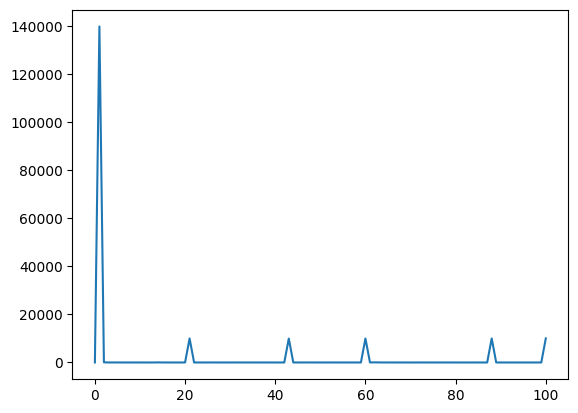

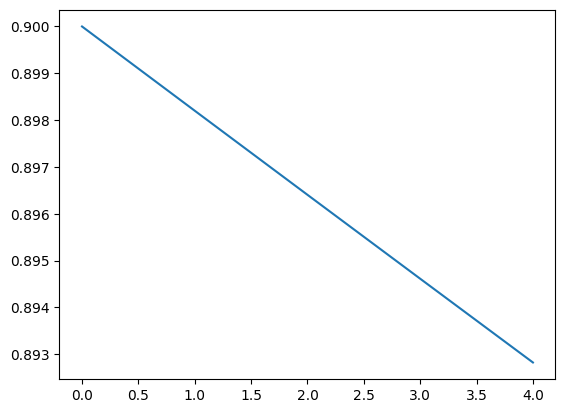

In [137]:
# Improvements needed
# 1) Normalize loss and value output
# 2) Separate model for prediction and evaluation
# 3) Memory replay for more stability
# 4) Possibly some rollout methods to look ahead
# 5) Decay in lr or epsilon
# 6) Make nn layers more complex
def train(model: nn.Module, optimizer: Adam, loss_func, episodes: int, env, gamma, epsilon_init, epsilon_final, epsilon_decay):
    # Cast model to cuda
    model = model.to(DEVICE)
    losses = []
    epsilons = []
    epsilon = epsilon_init
    for episode in tqdm(range(episodes)):
        # for each episode
        epsilons.append(epsilon)
        env.reset()
        while not env.done:
            # This is to enable self play
            active = -1
            if env.state[0].status == "ACTIVE":
                active=0
            if env.state[1].status == "ACTIVE":
                active=1
            
            observation = env.state[active].observation
            configuration = env.configuration
            myMark = observation.mark
            
            # Choose epsilon greedy action
            my_action = training_policy(env, model, observation.board, myMark, epsilon)   
            # Step depending on who's turn is it for self play
            env.step([my_action if i==active else None for i in [0,1]])
            steps = len(env.steps)
            # Current value of my after state (post action state)
            curAfterStateValue = model(observation.board, myMark)
            # Reward
            # Value of next after state (post action state of opponent), thus multiply -1 since zero sum game
            if env.done:
                reward = torch.as_tensor(100)
                nextAfterStateValue = 0
            else:
                reward = 0
                nextAfterStateValue = policy(env, model, observation.board, opponent_mark(myMark))[1] * -1
                
            # Need to improve this
            pred = curAfterStateValue
            target = reward + nextAfterStateValue * gamma
            loss = loss_func(pred, target)
            losses.append(float(loss))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # env.render(mode="ipython", width=100, height=90, header=False, controls=False)
        epsilon = max(epsilon * epsilon_decay, epsilon_final)
    plt.plot(losses, label="MSE_Loss")
    plt.show()
    plt.plot(epsilons, label="Epsilons")
    plt.show()

# Set up model and optimizer
numConvFilters = 500
filterSize = 4
# Input: after board state, player mark
# Output: Value of the after boardstate
model = ValueNetwork(numConvFilters, filterSize, env.configuration.columns, env.configuration.rows)
lr = 0.01
optimizer = Adam(model.parameters(), lr=lr)
epsilon_init = 0.9
epsilon_final = 0.01
epsilon_decay = 0.998
episodes = 5
gamma = 0.9

# Start Training
train(model, optimizer, nn.MSELoss(), episodes, env, gamma, epsilon_init, epsilon_final, epsilon_decay)

# Create Agent

In [130]:
# This agent random chooses a non-empty column.
def my_agent(observation, configuration):
    # Number of Columns on the Board: 7
    columns = configuration.columns
    # Number of Rows on the Board: 6
    rows = configuration.rows
    # Number of Checkers "in a row" needed to win: 4
    inarow = configuration.inarow
    # The current serialized Board (rows x columns).
    board = observation.board
    # Which player the agent is playing as (1 or 2).
    mark = observation.mark
    return policy(env, model, board, mark)[0]

# Test Agent

In [132]:
env.reset()
# Play as the first agent against default "random" agent.
env.run([my_agent, "random"])
env.render(mode="ipython", width=500, height=450)

# Evaluate your Agent

In [116]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.8
My Agent vs Negamax Agent: 0.0


# Play your Agent
Click on any column to place a checker there ("manually select action").

In [134]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, my_agent], width=500, height=450)

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.